In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F

In [0]:
transform = transforms.ToTensor()

train_val_dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)

In [0]:
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))

In [0]:
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])

In [0]:
batch_size = 32
epochs = 15
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [0]:
print("Train set contains %d images in %d batches" % (len(trainloader.dataset),len(trainloader)))
print("Validation set contains %d images in %d batches" % (len(valloader.dataset),len(valloader)))
print("Test set contains %d images in %d batches" % (len(testloader.dataset),len(testloader)))

Train set contains 48000 images in 1500 batches
Validation set contains 12000 images in 375 batches
Test set contains 10000 images in 313 batches


In [0]:
cuda = torch.cuda.is_available()
classes = ('tshirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot')

# Classifier

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.conv1_drop = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        #self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        #self.conv3_drop = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(3136,84)
        self.fc2 = nn.Linear(84,64)
        self.fc3 = nn.Linear(64,10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
classifier = Classifier()
if cuda:
    classifier = classifier.cuda()
classifier

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [0]:
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [0]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
    for images, labels in trainloader:
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        output = classifier(images)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)
  
    classifier.eval()
    total_correct = 0
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            output_acc = classifier(images)
            loss = criterion(output_acc,labels)
            current_val_loss += loss.item()*images.size(0)
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        val_loss = current_val_loss/len(valloader)
        validation_losses.append(val_loss)
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, train_loss, val_loss, accuracy))


Epoch: 1/15 	 Training Loss: 22.693002038637797, Validation loss: 13.120074685414632, Validation Accuracy: 0.8515
Epoch: 2/15 	 Training Loss: 11.596246702512106, Validation loss: 9.63192988204956, Validation Accuracy: 0.8880833333333333
Epoch: 3/15 	 Training Loss: 9.326432219823202, Validation loss: 8.723582443873088, Validation Accuracy: 0.8989166666666667
Epoch: 4/15 	 Training Loss: 8.216275620937347, Validation loss: 9.045497990290324, Validation Accuracy: 0.8953333333333333
Epoch: 5/15 	 Training Loss: 7.367490368207296, Validation loss: 8.378995071411133, Validation Accuracy: 0.902
Epoch: 6/15 	 Training Loss: 6.655696937878926, Validation loss: 8.29049013264974, Validation Accuracy: 0.9046666666666666
Epoch: 7/15 	 Training Loss: 6.050156524976095, Validation loss: 7.461751671473185, Validation Accuracy: 0.9165833333333333
Epoch: 8/15 	 Training Loss: 5.5428139667510985, Validation loss: 8.1536847337087, Validation Accuracy: 0.9118333333333334
Epoch: 9/15 	 Training Loss: 5.17

Text(0, 0.5, 'Loss')

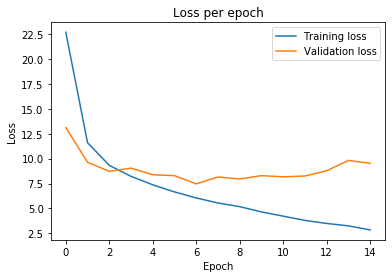

In [0]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [0]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    outputs = classifier(images.cuda())
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 88.028803 %
Accuracy of trouser : 99.277108 %
Accuracy of pullover : 88.405797 %
Accuracy of dress : 94.078399 %
Accuracy of  coat : 83.774834 %
Accuracy of sandal : 97.781430 %
Accuracy of shirt : 76.074136 %
Accuracy of sneaker : 97.706032 %
Accuracy of   bag : 98.747913 %
Accuracy of ankle boot : 96.381579 %


In [0]:
total_correct = 0
total_loss = 0
with torch.no_grad():
    classifier.eval()
    for images, labels in testloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images,labels = images.cuda(),labels.cuda()
        output_acc = classifier(images)
        loss = criterion(output_acc,labels)
        _, pred = torch.max(output_acc, 1)
        total_correct += torch.sum(pred==labels).item()
        total_loss += loss.item()*images.size(0)
    test_loss = total_loss/len(testloader)
    accuracy = total_correct / len(testloader.dataset)
print("Test loss: {}, accuracy: {}".format(test_loss,accuracy))

Test loss: 9.215004491348997, accuracy: 0.9098


# Autoencoder

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
auto = AutoEncoder()
if cuda:
    auto = auto.cuda()
auto

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout2d(p=0.25, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [0]:
optimizer = optim.SGD(auto.parameters(), lr=0.5, momentum=0.9)
criterion = nn.MSELoss()

In [0]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
    for images, labels in trainloader:
        #images = images.view(images.size()[0], -1)
        if cuda:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = auto(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)
    
    auto.eval()
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            if cuda:
                images, labels = images.cuda(), labels.cuda()
            output = auto(images)
            loss = criterion(output,images)
            current_val_loss += loss.item()*images.size(0)
        val_loss = current_val_loss/len(valloader)
        validation_losses.append(val_loss)
    
    print('Epoch: {}/{} \t Training Loss: {} Validation Loss: {}'.format(epoch+1, epochs, train_loss,val_loss))

Epoch: 1/15 	 Training Loss: 0.5328459071914355 Validation Loss: 0.3223979793389638
Epoch: 2/15 	 Training Loss: 0.1763034479767084 Validation Loss: 0.14827404630184174
Epoch: 3/15 	 Training Loss: 0.13687072285513083 Validation Loss: 0.12603301189343136
Epoch: 4/15 	 Training Loss: 0.12146294065813223 Validation Loss: 0.11491109140714009
Epoch: 5/15 	 Training Loss: 0.11206777921815714 Validation Loss: 0.10826216729482015
Epoch: 6/15 	 Training Loss: 0.10576869910458724 Validation Loss: 0.10159646014372507
Epoch: 7/15 	 Training Loss: 0.1009118885397911 Validation Loss: 0.09809891561667125
Epoch: 8/15 	 Training Loss: 0.09717341610540946 Validation Loss: 0.09446141664187113
Epoch: 9/15 	 Training Loss: 0.09413835819313923 Validation Loss: 0.09182896052797636
Epoch: 10/15 	 Training Loss: 0.09150654701143503 Validation Loss: 0.08946823263168335
Epoch: 11/15 	 Training Loss: 0.0891683226202925 Validation Loss: 0.08875942267974218
Epoch: 12/15 	 Training Loss: 0.08743046654512485 Validat

Text(0, 0.5, 'Loss')

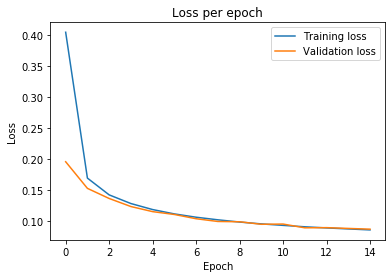

In [0]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

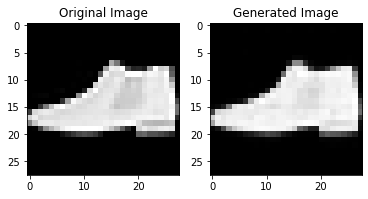

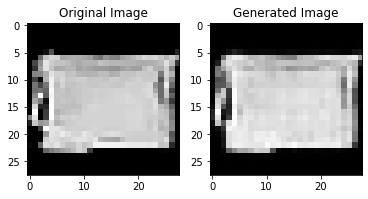

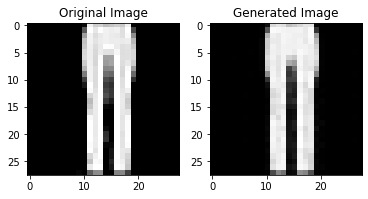

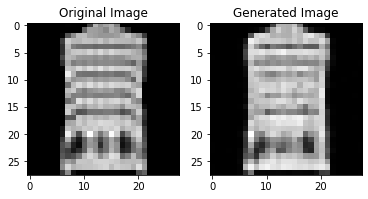

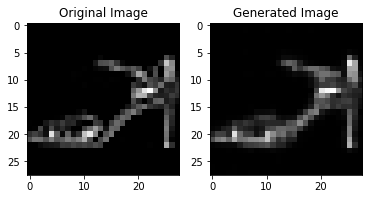

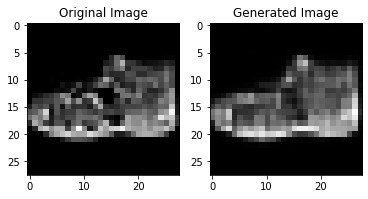

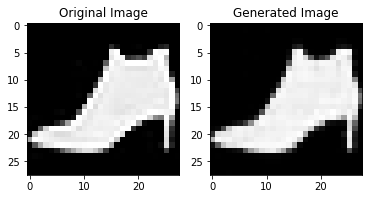

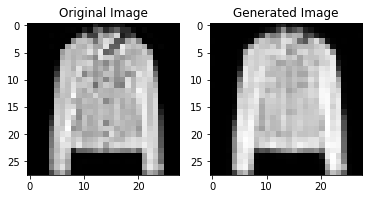

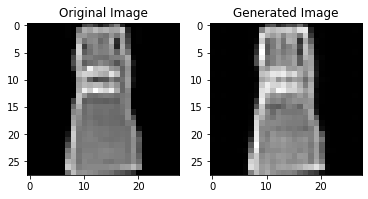

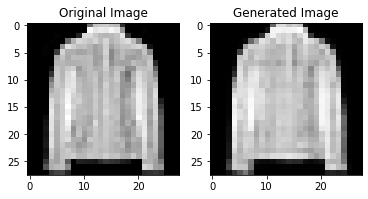

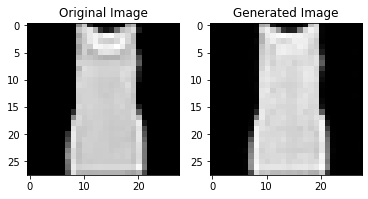

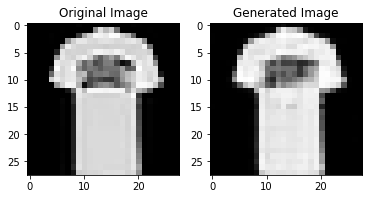

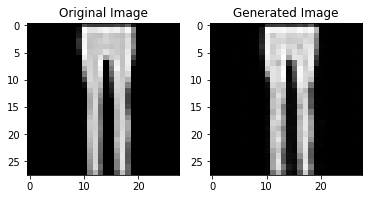

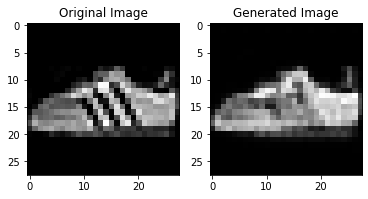

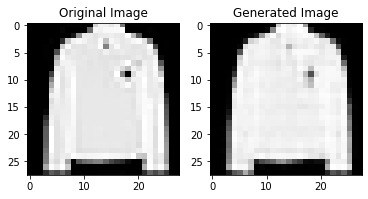

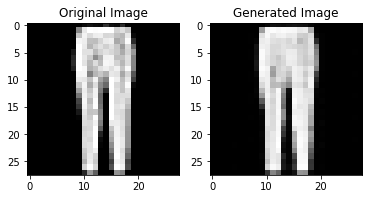

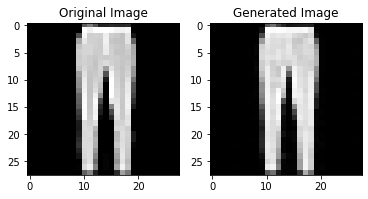

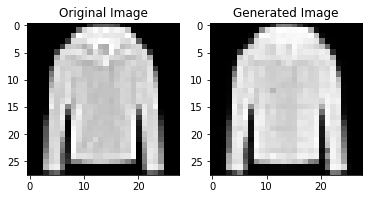

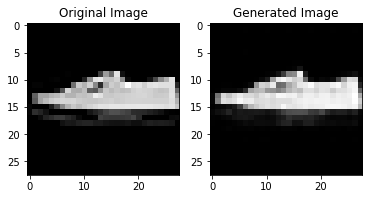

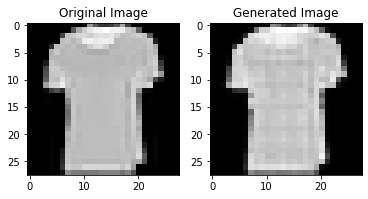

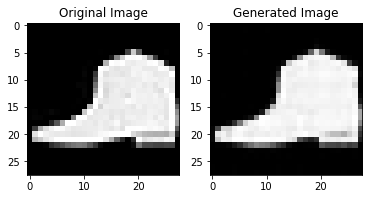

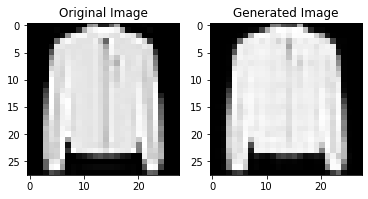

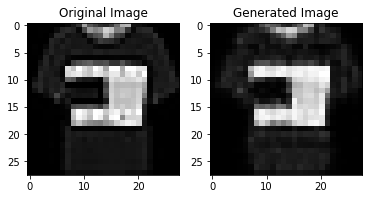

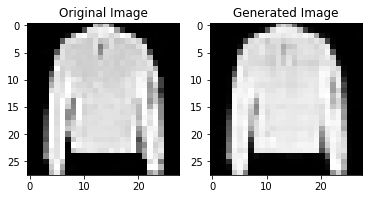

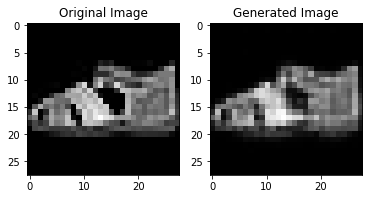

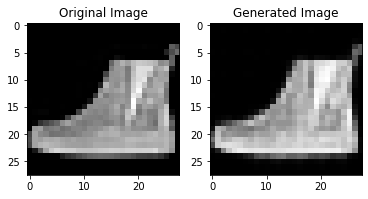

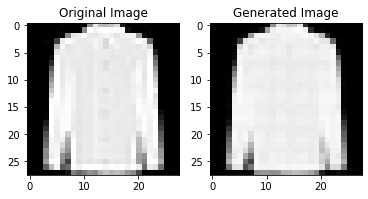

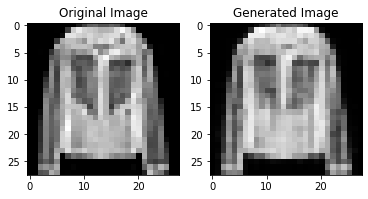

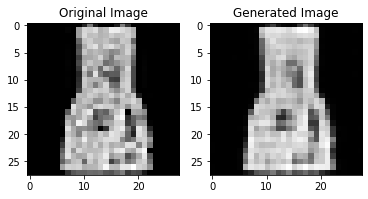

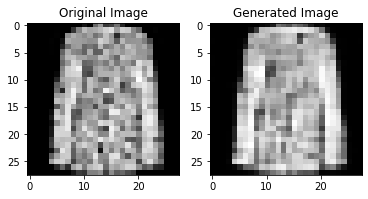

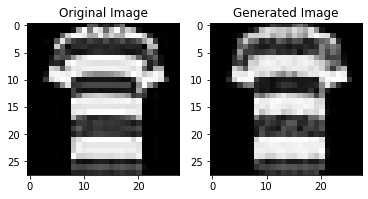

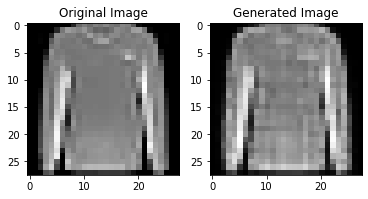

In [0]:
test_images, labels = next(iter(valloader))
#test_images = test_images.view(test_images.size()[0], -1)
if cuda:
    test_images = test_images.cuda()
test_output = auto(test_images)
  
inp = test_images.view(-1,28,28)
out = test_output.view(-1,28,28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

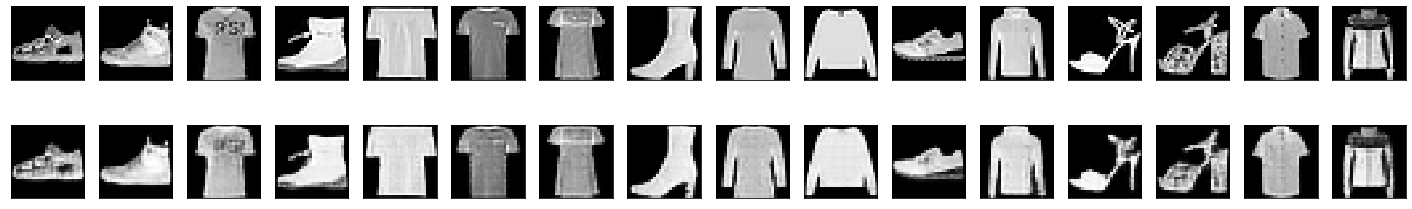

In [0]:

dataiter = iter(valloader)
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()

output = auto(images)                     
images = images.cpu().numpy()#
output = output.cpu()
output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()           

fig, axes = plt.subplots(nrows=2, ncols=16, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [0]:
total_loss = 0
with torch.no_grad():
    classifier.eval()
    for images, labels in testloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images,labels = images.cuda(),labels.cuda()
        output = auto(images)
        loss = criterion(output,images)
        total_loss += loss.item()*images.size(0)
    test_loss = total_loss/len(testloader)
print("Test loss: {}".format(test_loss))

Test loss: 0.08756008405036057


In [0]:
class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for images,labels in valloader:
    #decoded, outputs = net3(Variable(images.view(-1, 28*28).cuda()))
    decoded, outputs = net3(images.cuda())
    _, predicted = torch.max(outputs.cpu(), 1)
    c = (predicted == labels)
    for i in range(batch_size):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of tshirt : 0.000000 %
Accuracy of trouser : 100.000000 %
Accuracy of pullover : 0.000000 %
Accuracy of dress : 0.000000 %
Accuracy of  coat : 0.000000 %
Accuracy of sandal : 0.000000 %
Accuracy of shirt : 0.000000 %
Accuracy of sneaker : 0.000000 %
Accuracy of   bag : 0.000000 %
Accuracy of ankle boot : 0.000000 %


# Autoencoder + Classifier Combined Model (two losses)

In [0]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,kernel_size=2,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1,kernel_size=2,stride=2),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(3136,128),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(128,64),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(encoded.size(0),-1)
        predicted = self.classifier(encoded)
        return decoded, predicted
net3 = Mixed()
net3 = net3.cuda()
net3

Mixed(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.25, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Dropout2d(p=0.25, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [0]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr=0.01, momentum=0.9)

In [0]:
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
  
    for images, labels in trainloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images, labels = images.cuda(),labels.cuda()
        decoded, predicted = net3(images)
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted, labels)
        loss = loss1+loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)

    net3.eval()
    total_correct = 0
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            images, labels = images.cuda(),labels.cuda()
            decoded, output_acc = net3(images)
            val_loss1 = criterion1(decoded,images)
            val_loss2 = criterion2(output_acc, labels)
            total_val_loss = val_loss1+val_loss2
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
            current_val_loss += total_val_loss.item()*images.size(0)
        val_loss = current_val_loss/len(valloader)
        validation_losses.append(val_loss)
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, train_loss, val_loss, accuracy))

Epoch: 1/30 	 Training Loss: 31.90999757385254, Validation loss: 17.0308329633077, Validation Accuracy: 0.817
Epoch: 2/30 	 Training Loss: 13.773245373407999, Validation loss: 11.213611085255941, Validation Accuracy: 0.8751666666666666
Epoch: 3/30 	 Training Loss: 10.954369217077891, Validation loss: 10.081606044769288, Validation Accuracy: 0.8930833333333333
Epoch: 4/30 	 Training Loss: 9.697566384712855, Validation loss: 9.284227262179057, Validation Accuracy: 0.8981666666666667
Epoch: 5/30 	 Training Loss: 8.895252367258072, Validation loss: 8.711811296145122, Validation Accuracy: 0.9066666666666666
Epoch: 6/30 	 Training Loss: 8.12348548857371, Validation loss: 8.72658814016978, Validation Accuracy: 0.907
Epoch: 7/30 	 Training Loss: 7.574909686247508, Validation loss: 8.093781208674113, Validation Accuracy: 0.9118333333333334
Epoch: 8/30 	 Training Loss: 7.03665255745252, Validation loss: 8.411675322214762, Validation Accuracy: 0.909
Epoch: 9/30 	 Training Loss: 6.545948822220167,

Text(0, 0.5, 'Loss')

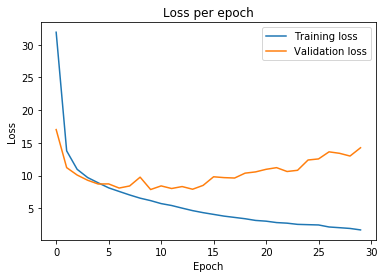

In [0]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

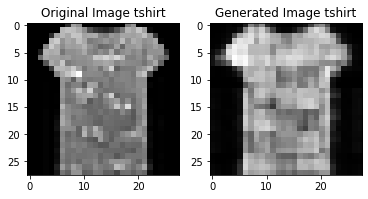

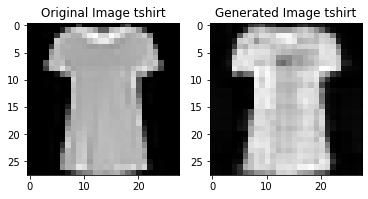

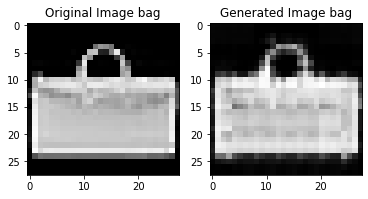

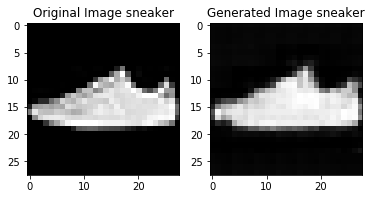

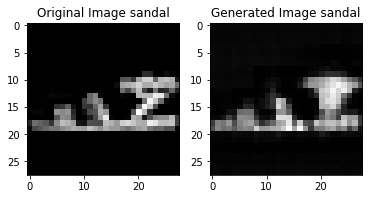

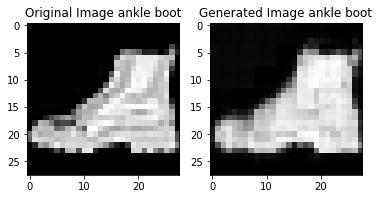

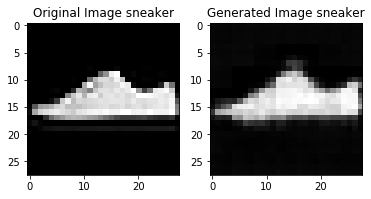

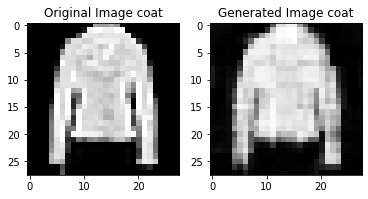

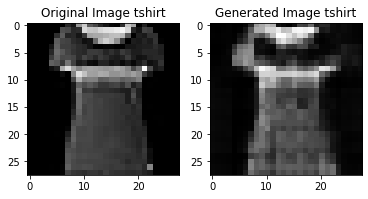

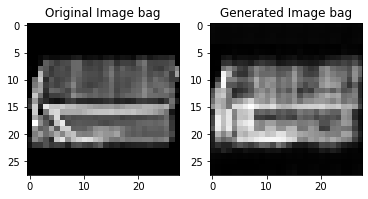

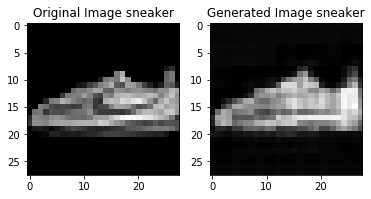

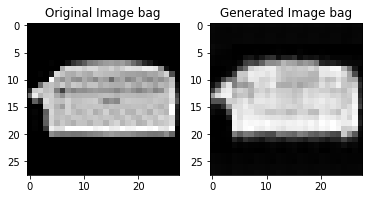

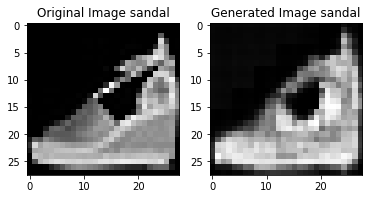

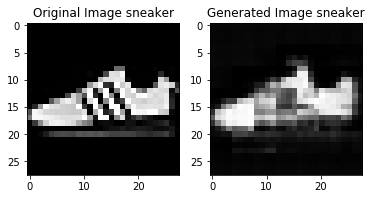

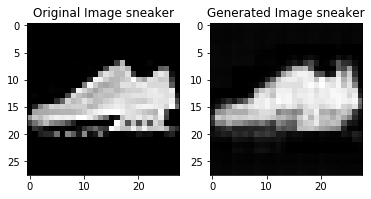

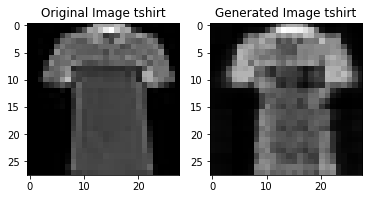

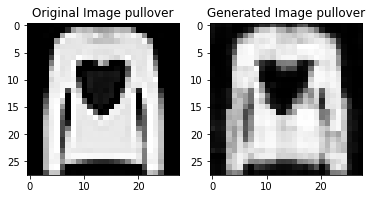

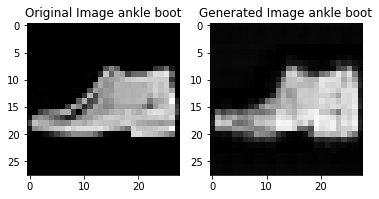

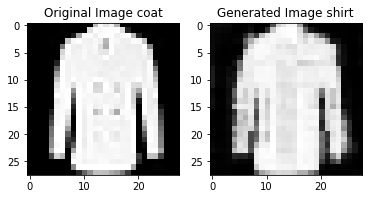

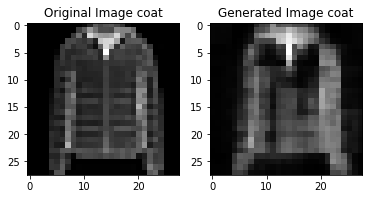

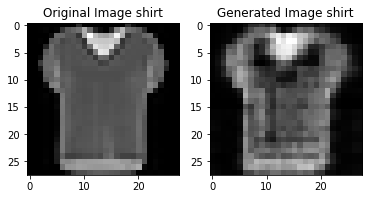

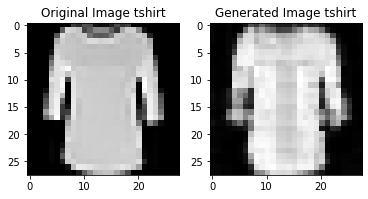

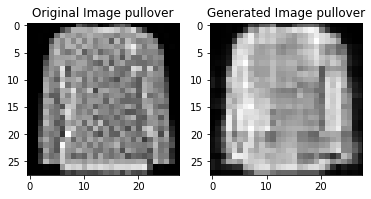

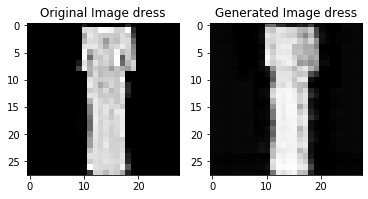

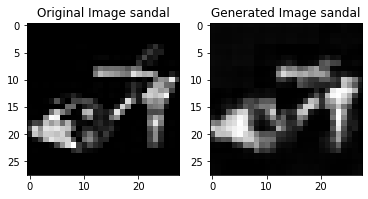

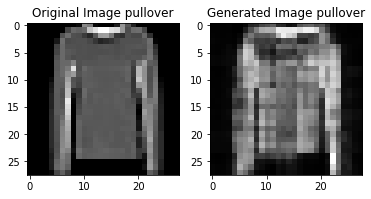

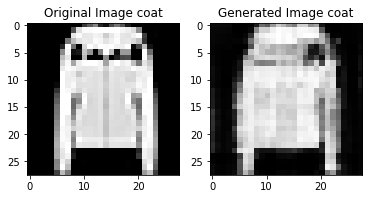

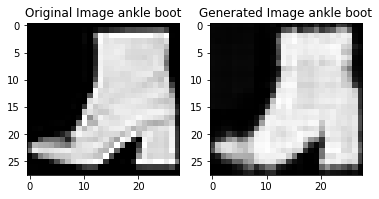

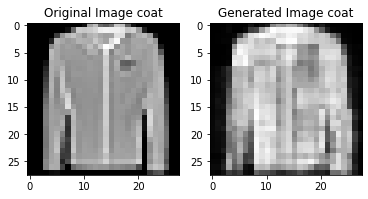

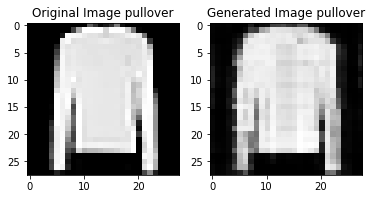

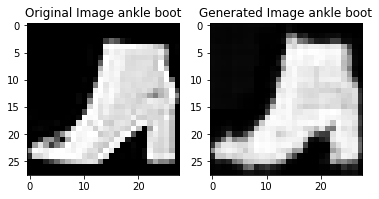

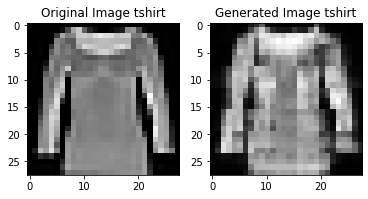

In [0]:
test_images, labels = next(iter(valloader))

#test_images = test_images.view(test_images.size()[0], -1).cuda()
test_images, labels = test_images.cuda(),labels.cuda()
test_output, predicted = net3(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    #print("Ground truth", classes[labels[i]])
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    #print("Predicted", classes[predicted_label[i]])
    plt.show()

In [0]:
#just autoencoder loss
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
  
    for images, labels in trainloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images, labels = images.cuda(),labels.cuda()
        decoded, predicted = net3(images)
        loss = criterion1(decoded,images)
        #loss2 = criterion2(predicted, labels)
        #loss = loss1+loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)

    net3.eval()
    total_correct = 0
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            images, labels = images.cuda(),labels.cuda()
            decoded, output_acc = net3(images)
            val_loss = criterion1(decoded,images)
            #val_loss2 = criterion2(output_acc, labels)
            #total_val_loss = val_loss1+val_loss2
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
            current_val_loss += val_loss.item()*images.size(0)
        total_val_loss = current_val_loss/len(valloader)
        validation_losses.append(total_val_loss)
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, train_loss, total_val_loss, accuracy))

Epoch: 1/15 	 Training Loss: 2.139215776960055, Validation loss: 0.8278811246554056, Validation Accuracy: 0.06975
Epoch: 2/15 	 Training Loss: 0.6626344749927521, Validation loss: 0.5797674210071564, Validation Accuracy: 0.03166666666666667
Epoch: 3/15 	 Training Loss: 0.5441021178364753, Validation loss: 0.5130509818394979, Validation Accuracy: 0.030833333333333334
Epoch: 4/15 	 Training Loss: 0.4933173653483391, Validation loss: 0.4729494837919871, Validation Accuracy: 0.026833333333333334
Epoch: 5/15 	 Training Loss: 0.4576657245159149, Validation loss: 0.4410068582693736, Validation Accuracy: 0.02808333333333333
Epoch: 6/15 	 Training Loss: 0.42804199508825935, Validation loss: 0.4141262776851654, Validation Accuracy: 0.034333333333333334
Epoch: 7/15 	 Training Loss: 0.40355924928188325, Validation loss: 0.3922217508951823, Validation Accuracy: 0.04375
Epoch: 8/15 	 Training Loss: 0.38379613918066025, Validation loss: 0.37461890014012655, Validation Accuracy: 0.05441666666666667
Ep

Text(0, 0.5, 'Loss')

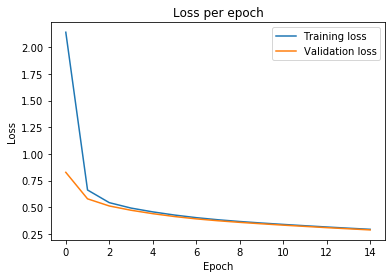

In [0]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

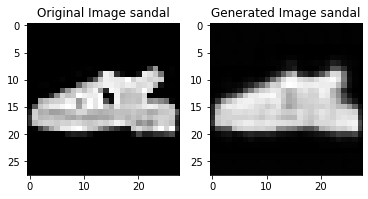

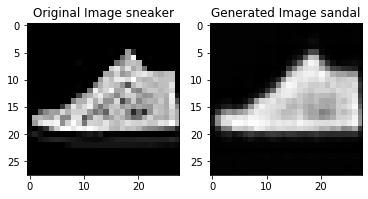

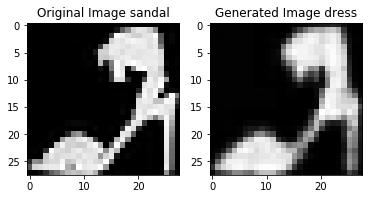

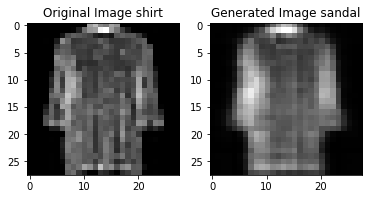

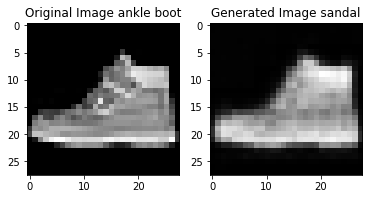

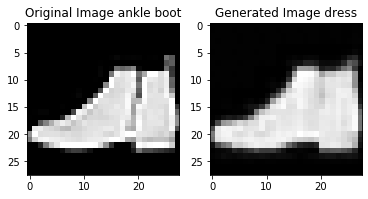

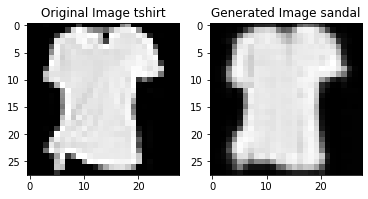

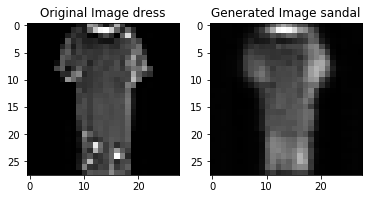

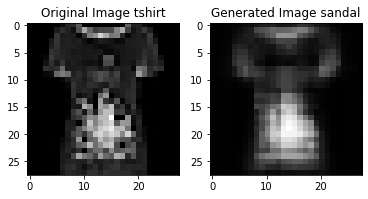

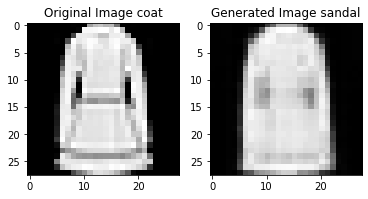

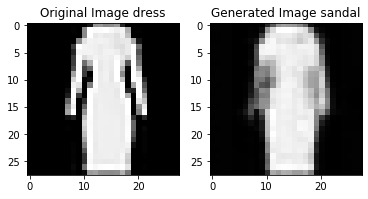

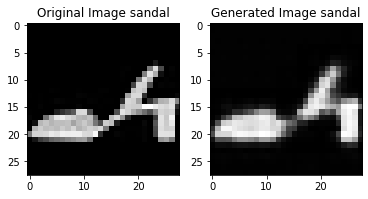

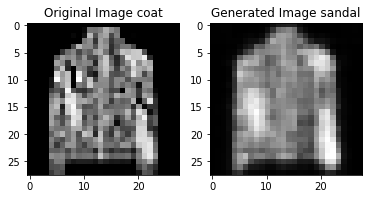

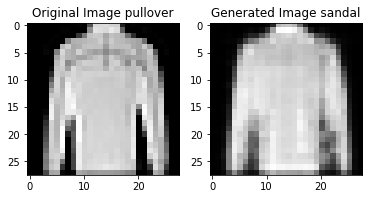

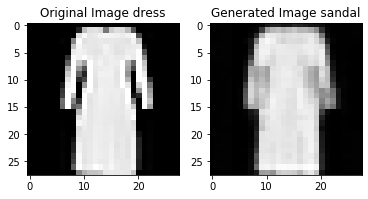

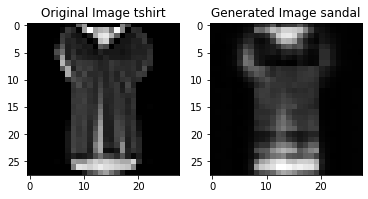

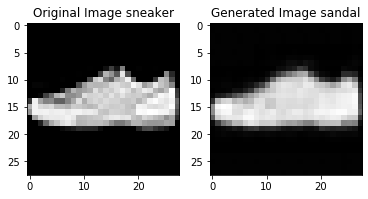

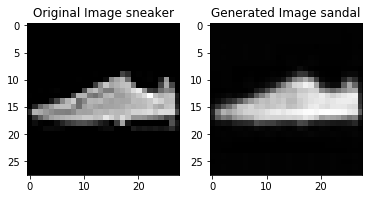

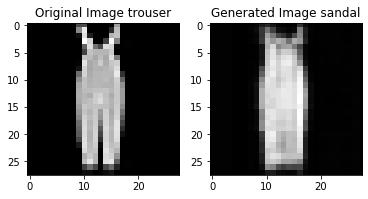

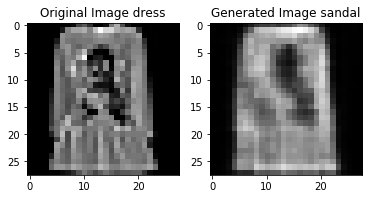

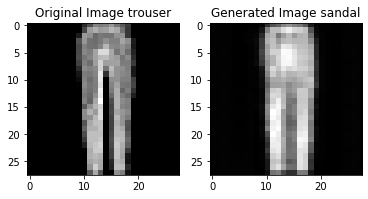

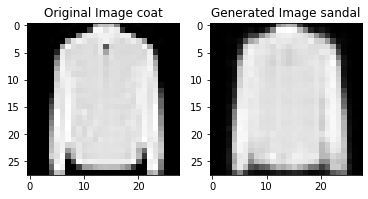

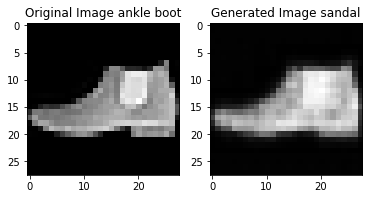

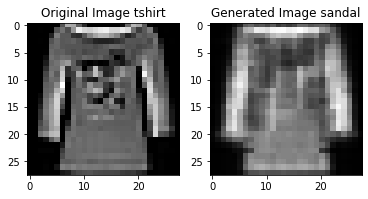

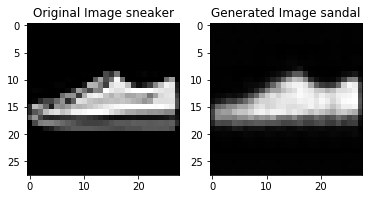

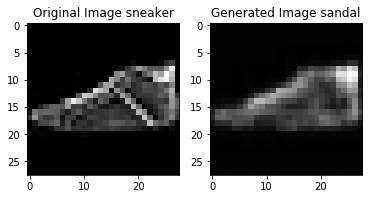

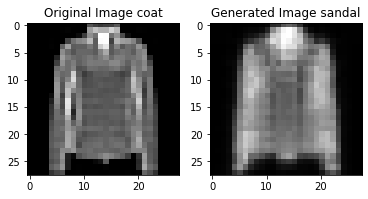

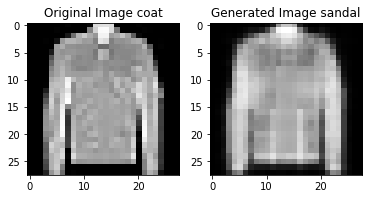

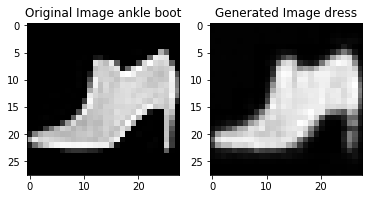

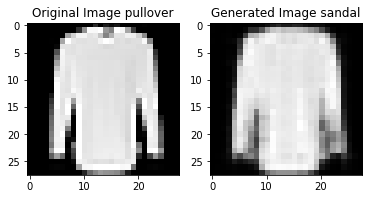

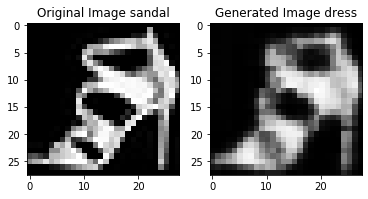

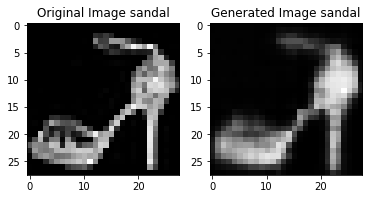

In [0]:
test_images, labels = next(iter(valloader))

#test_images = test_images.view(test_images.size()[0], -1).cuda()
test_images, labels = test_images.cuda(),labels.cuda()
test_output, predicted = net3(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    #print("Ground truth", classes[labels[i]])
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    #print("Predicted", classes[predicted_label[i]])
    plt.show()

In [0]:
#just classifier loss
training_losses = []
validation_losses = []
for epoch in range(epochs):
    current_train_loss = 0
  
    for images, labels in trainloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images, labels = images.cuda(),labels.cuda()
        decoded, predicted = net3(images)
        #loss = criterion1(decoded,images)
        loss = criterion2(predicted, labels)
        #loss = loss1+loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_train_loss += loss.item()*images.size(0)
    train_loss = current_train_loss/len(trainloader)
    training_losses.append(train_loss)

    net3.eval()
    total_correct = 0
    current_val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            images, labels = images.cuda(),labels.cuda()
            decoded, output_acc = net3(images)
            #val_loss = criterion1(decoded,images)
            val_loss = criterion2(output_acc, labels)
            #total_val_loss = val_loss1+val_loss2
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
            current_val_loss += val_loss.item()*images.size(0)
        total_val_loss = current_val_loss/len(valloader)
        validation_losses.append(total_val_loss)
        accuracy = total_correct / len(valloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Validation loss: {}, Validation Accuracy: {}'.format(epoch+1, epochs, train_loss, total_val_loss, accuracy))

Epoch: 1/15 	 Training Loss: 22.267809847831725, Validation loss: 12.89128192138672, Validation Accuracy: 0.85625
Epoch: 2/15 	 Training Loss: 11.579796534379323, Validation loss: 9.443055530548095, Validation Accuracy: 0.8945
Epoch: 3/15 	 Training Loss: 9.374155285199484, Validation loss: 9.386255015691122, Validation Accuracy: 0.8958333333333334
Epoch: 4/15 	 Training Loss: 8.143417920748393, Validation loss: 8.176617167790731, Validation Accuracy: 0.90675
Epoch: 5/15 	 Training Loss: 7.331073594252269, Validation loss: 7.884235380172729, Validation Accuracy: 0.9111666666666667
Epoch: 6/15 	 Training Loss: 6.684362065315247, Validation loss: 7.760025319417318, Validation Accuracy: 0.9098333333333334
Epoch: 7/15 	 Training Loss: 6.049000975767771, Validation loss: 7.702330837885539, Validation Accuracy: 0.9120833333333334
Epoch: 8/15 	 Training Loss: 5.459812636693319, Validation loss: 6.998362730662028, Validation Accuracy: 0.922
Epoch: 9/15 	 Training Loss: 4.967704378445943, Valid

Text(0, 0.5, 'Loss')

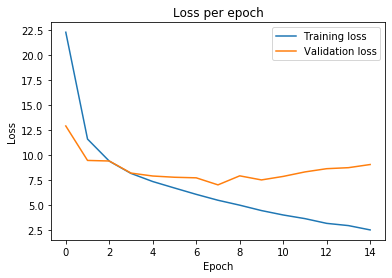

In [0]:
plt.plot(range(epochs),training_losses,label="Training loss")
plt.plot(range(epochs),validation_losses,label="Validation loss")
plt.legend()
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

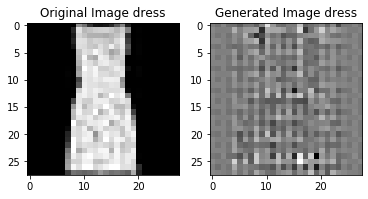

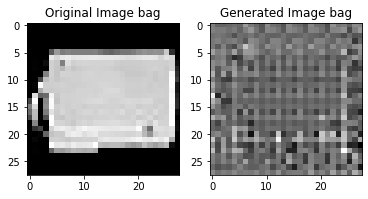

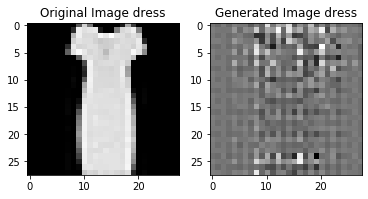

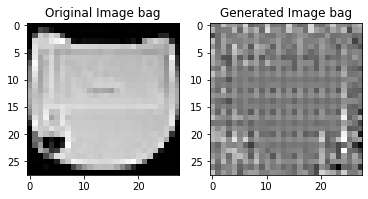

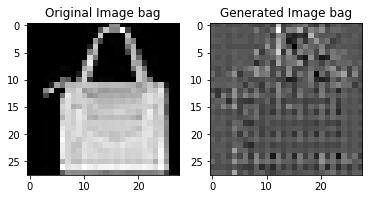

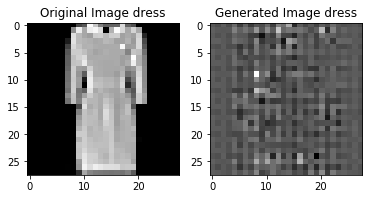

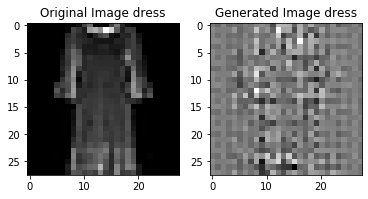

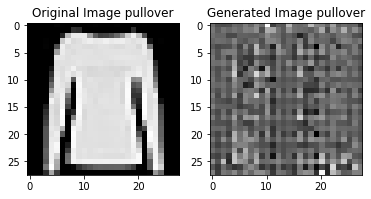

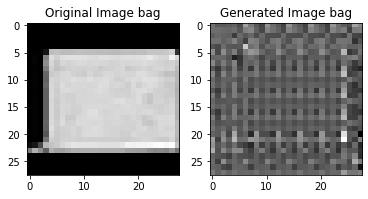

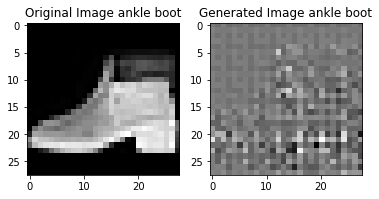

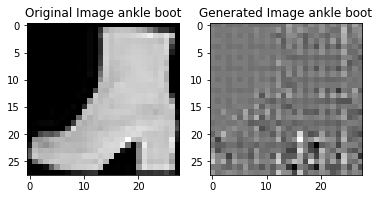

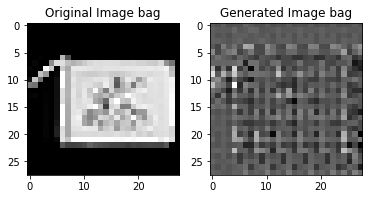

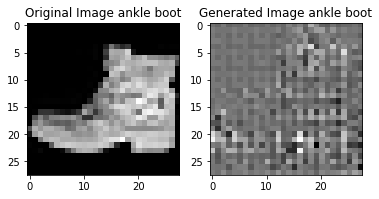

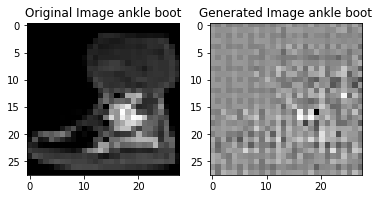

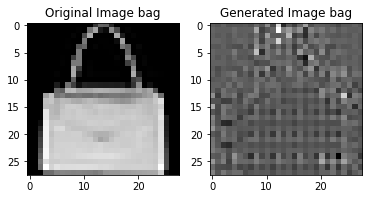

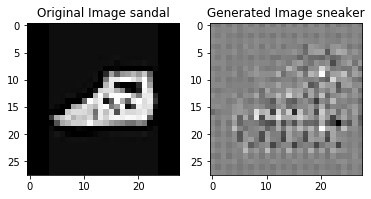

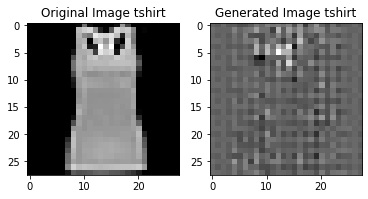

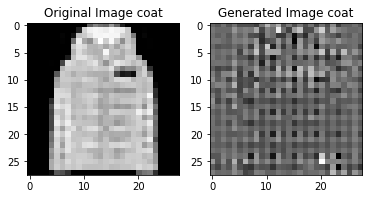

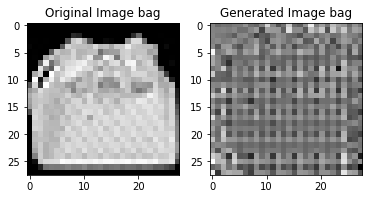

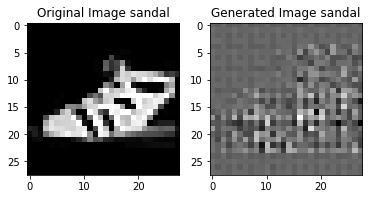

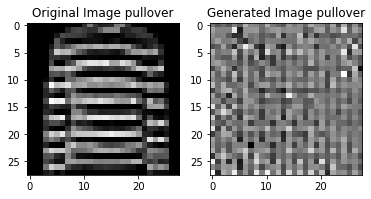

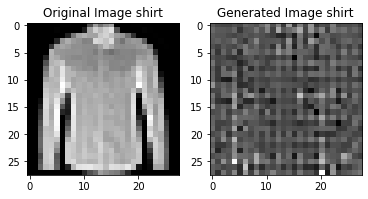

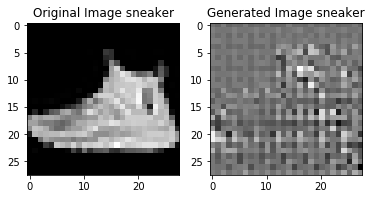

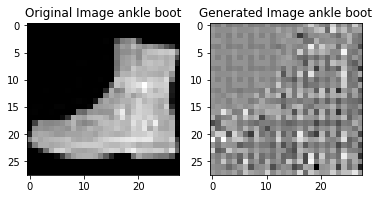

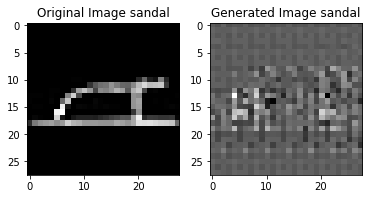

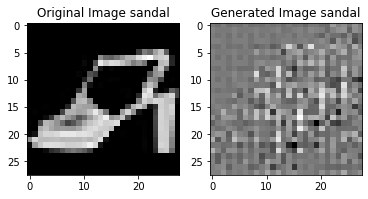

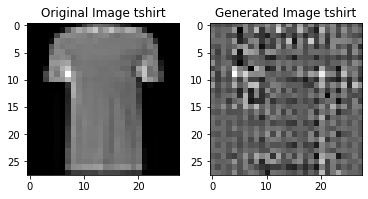

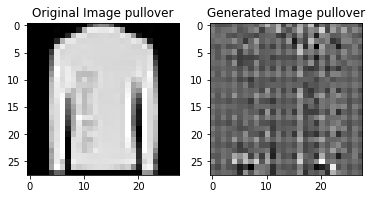

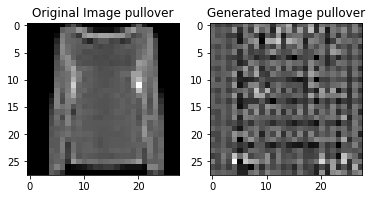

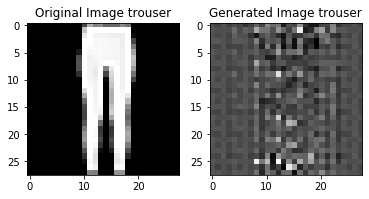

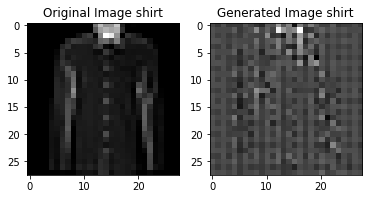

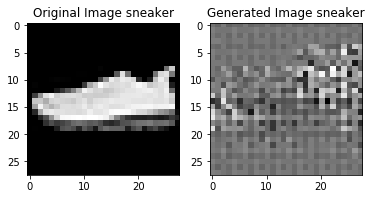

In [0]:
test_images, labels = next(iter(valloader))

#test_images = test_images.view(test_images.size()[0], -1).cuda()
test_images, labels = test_images.cuda(),labels.cuda()
test_output, predicted = net3(test_images)
_, predicted_label = torch.max(predicted, 1)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')
    #print("Ground truth", classes[labels[i]])
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    #print("Predicted", classes[predicted_label[i]])
    plt.show()

In [0]:
total_correct = 0
total_loss = 0
with torch.no_grad():
    net3.eval()
    for images, labels in testloader:
        #images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        images,labels = images.cuda(),labels.cuda()
        decoded, output_acc = net3(images)
        test_loss1 = criterion1(decoded,images)
        test_loss2 = criterion2(output_acc, labels)
        test_loss = test_loss1+test_loss2
        _, pred = torch.max(output_acc, 1)
        total_correct += torch.sum(pred==labels).item()
        total_loss += test_loss.item()*images.size(0)
    final_loss = total_loss/len(testloader)
    accuracy = total_correct / len(testloader.dataset)
print("Test loss: {}, accuracy: {}".format(final_loss,accuracy))

Test loss: 29.29039584904814, accuracy: 0.9097
